In [1]:
from time import time

import numpy as np
import pandas as pd
import matplotlib as plt
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.svm import LinearSVC

Считываю данные из файла __train.csv__, используя средства библиотеки _pandas_, и визуализирую их. Таким образом имеется ___489517___ классифицированных объявлений:

In [2]:
X_reader = []
y_reader = []
data_train = pd.read_csv("data/train.csv")
data_train

,item_id,title,description,price,category_id
0,0,Картина,Гобелен. Размеры 139х84см.,1000.0,19
1,1,Стулья из прессованной кожи,Продам недорого 4 стула из светлой прессованно...,1250.0,22
2,2,Домашняя мини баня,"Мини баня МБ-1(мини сауна), предназначена для ...",13000.0,37
3,3,"Эксклюзивная коллекция книг ""Трансаэро"" + подарок","Продам эксклюзивную коллекцию книг, выпущенную...",4000.0,43
4,4,Ноутбук aser,Продаётся ноутбук ACER e5-511C2TA. Куплен в ко...,19000.0,1
5,5,Бас гитара invasion bg110,Состояние хорошее. Имеется теплый чехол .,3999.0,50
6,6,"Смесь ""Грудничок"" г. Зеленодольск",Смесь молочная адаптированная ультрапастеризов...,15.0,41
7,7,G-shock,Часы абсолютно новые! с коробкой. Часы Китай...,2500.0,36
8,8,"Санатории Белоруссии. - ""Лепельский военный""",Санатории Белоруссии! - «Лепельский военный» ...,1090.0,48
9,9,Фотохолст,Фотохолст на подрамнике. 36х58см. Галерейная н...,1250.0,19


Данные из файла __train.csv__ классифицированы по категориям. Сами категории имеют иерархичную структуру, но различные категории имеют различное количество уровней иерархии. Считываю данные из файла __category.csv__ и визуализирую их с помощью средств _pandas_ в виде объекта __DataFrame__. Так как категории имеют различную глубину иерархии, я продолжаю иерархию (там где это нужно) повторением последнего элемента, например: _Бытовая электроника|Ноутбуки|Ноутбуки|Ноутбуки_. То есть для каждой категории уравниваю количество уровней иерархии до 4. Я делаю это, чтобы в дальнейшем мне было удобно реализовать обучение классификатора на разных уровнях иерархии:

In [3]:
data_categories_read = pd.read_csv("data/category.csv")

data_categories = data_categories_read.name.str.split('|', expand=True).reset_index()
data_categories.columns = ['category_id','hierarchy 1','hierarchy 2','hierarchy 3','hierarchy 4']
data_categories = data_categories.transpose().fillna(method='ffill').transpose()

hierarchy_1 = data_categories['hierarchy 1']
hierarchy_2 = hierarchy_1.str.cat(data_categories['hierarchy 2'], sep='|')
hierarchy_3 = hierarchy_2.str.cat(data_categories['hierarchy 2'], sep='|')
hierarchy_4 = hierarchy_3.str.cat(data_categories['hierarchy 3'], sep='|')

data_categories = pd.DataFrame({ 'category_id' : data_categories['category_id'],
                                 'hierarchy_1' : hierarchy_1,
                                 'hierarchy_2' : hierarchy_2,
                                 'hierarchy_3' : hierarchy_3,
                                 'hierarchy_4' : hierarchy_4})
data_categories

,category_id,hierarchy_1,hierarchy_2,hierarchy_3,hierarchy_4
0,0,Бытовая электроника,Бытовая электроника|Телефоны,Бытовая электроника|Телефоны|Телефоны,Бытовая электроника|Телефоны|Телефоны|iPhone
1,1,Бытовая электроника,Бытовая электроника|Ноутбуки,Бытовая электроника|Ноутбуки|Ноутбуки,Бытовая электроника|Ноутбуки|Ноутбуки|Ноутбуки
2,2,Бытовая электроника,Бытовая электроника|Телефоны,Бытовая электроника|Телефоны|Телефоны,Бытовая электроника|Телефоны|Телефоны|Samsung
3,3,Бытовая электроника,Бытовая электроника|Планшеты и электронные книги,Бытовая электроника|Планшеты и электронные кни...,Бытовая электроника|Планшеты и электронные кни...
4,4,Бытовая электроника,"Бытовая электроника|Игры, приставки и программы","Бытовая электроника|Игры, приставки и программ...","Бытовая электроника|Игры, приставки и программ..."
5,5,Бытовая электроника,Бытовая электроника|Аудио и видео,Бытовая электроника|Аудио и видео|Аудио и видео,Бытовая электроника|Аудио и видео|Аудио и виде...
6,6,Бытовая электроника,Бытовая электроника|Телефоны,Бытовая электроника|Телефоны|Телефоны,Бытовая электроника|Телефоны|Телефоны|Другие м...
7,7,Бытовая электроника,Бытовая электроника|Настольные компьютеры,Бытовая электроника|Настольные компьютеры|Наст...,Бытовая электроника|Настольные компьютеры|Наст...
8,8,Бытовая электроника,"Бытовая электроника|Игры, приставки и программы","Бытовая электроника|Игры, приставки и программ...","Бытовая электроника|Игры, приставки и программ..."
9,9,Бытовая электроника,Бытовая электроника|Телефоны,Бытовая электроника|Телефоны|Телефоны,Бытовая электроника|Телефоны|Телефоны|Аксессуары


Добавляю столбцы с уровнями категориальной иерархии к исходным данным, чтобы сопоставить каждому __'item_id'__ свое значение категории __'hierarchy_n'__ (n - уровень иерархии) по каждому иерархическому уровню:

In [4]:
data_train = pd.merge(data_train, data_categories, on="category_id")
data_train = data_train.sort_values(by='item_id')
data_train

,item_id,title,description,price,category_id,hierarchy_1,hierarchy_2,hierarchy_3,hierarchy_4
0,0,Картина,Гобелен. Размеры 139х84см.,1000.0,19,Для дома и дачи,Для дома и дачи|Мебель и интерьер,Для дома и дачи|Мебель и интерьер|Мебель и инт...,Для дома и дачи|Мебель и интерьер|Мебель и инт...
8906,1,Стулья из прессованной кожи,Продам недорого 4 стула из светлой прессованно...,1250.0,22,Для дома и дачи,Для дома и дачи|Мебель и интерьер,Для дома и дачи|Мебель и интерьер|Мебель и инт...,Для дома и дачи|Мебель и интерьер|Мебель и инт...
18561,2,Домашняя мини баня,"Мини баня МБ-1(мини сауна), предназначена для ...",13000.0,37,Личные вещи,Личные вещи|Красота и здоровье,Личные вещи|Красота и здоровье|Красота и здоровье,Личные вещи|Красота и здоровье|Красота и здоро...
28445,3,"Эксклюзивная коллекция книг ""Трансаэро"" + подарок","Продам эксклюзивную коллекцию книг, выпущенную...",4000.0,43,Хобби и отдых,Хобби и отдых|Книги и журналы,Хобби и отдых|Книги и журналы|Книги и журналы,Хобби и отдых|Книги и журналы|Книги и журналы|...
37510,4,Ноутбук aser,Продаётся ноутбук ACER e5-511C2TA. Куплен в ко...,19000.0,1,Бытовая электроника,Бытовая электроника|Ноутбуки,Бытовая электроника|Ноутбуки|Ноутбуки,Бытовая электроника|Ноутбуки|Ноутбуки|Ноутбуки
45532,5,Бас гитара invasion bg110,Состояние хорошее. Имеется теплый чехол .,3999.0,50,Хобби и отдых,Хобби и отдых|Музыкальные инструменты,Хобби и отдых|Музыкальные инструменты|Музыкаль...,Хобби и отдых|Музыкальные инструменты|Музыкаль...
54911,6,"Смесь ""Грудничок"" г. Зеленодольск",Смесь молочная адаптированная ультрапастеризов...,15.0,41,Личные вещи,Личные вещи|Товары для детей и игрушки,Личные вещи|Товары для детей и игрушки|Товары ...,Личные вещи|Товары для детей и игрушки|Товары ...
63790,7,G-shock,Часы абсолютно новые! с коробкой. Часы Китай...,2500.0,36,Личные вещи,Личные вещи|Часы и украшения,Личные вещи|Часы и украшения|Часы и украшения,Личные вещи|Часы и украшения|Часы и украшения|...
73022,8,"Санатории Белоруссии. - ""Лепельский военный""",Санатории Белоруссии! - «Лепельский военный» ...,1090.0,48,Хобби и отдых,Хобби и отдых|Билеты и путешествия,Хобби и отдых|Билеты и путешествия|Билеты и пу...,Хобби и отдых|Билеты и путешествия|Билеты и пу...
1,9,Фотохолст,Фотохолст на подрамнике. 36х58см. Галерейная н...,1250.0,19,Для дома и дачи,Для дома и дачи|Мебель и интерьер,Для дома и дачи|Мебель и интерьер|Мебель и инт...,Для дома и дачи|Мебель и интерьер|Мебель и инт...


Предобратка данных для дальнейшего их использования при обучении классификатора. В качестве данных для обучения я выбрал текстовые данные, которые помещаю в __X_train_read__. Для их предобработки я использую средства библиотеки __scikit_learn: sklearn.feature_extraction.text.CountVectorizer().fit_transform()__
Данный метод преобразует текст в матрицу объектов и признаков (__[n_samples, n_features]__), с которой будет работать классификатор. В данном случае количество признаков равно размеру словаря, который рассматриваемый метод образует при анализе данных.
http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
На выходе из CountVectorizer().fit_transform имеем __X_train__, который представляет из себя матрицу объектов и признаков. 
В данном случае в качестве сырых текстовых данных выбраны названия (__'title'__) объявлений, ниже будет пояснено - почему.

In [5]:
X_train_read = data_train['title']

vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train_read)
X_train

<489517x155473 sparse matrix of type '<class 'numpy.int64'>'
	with 1791957 stored elements in Compressed Sparse Row format>

В качестве классификатора, для начала, мною был выбран _наивный байесовский классификатор_, как относительно простой и популярный метод классификации текста:
https://en.wikipedia.org/wiki/Naive_Bayes_classifier
В качестве реализации наивного байесовского классификатора в данной задаче была выбрана модель __Multinomial naive Bayes__, подходящая для классификации дискретных функций (в данном случае подсчет слов в тексте). Однако, ниже представлено, что также можно использовать классификатор с _моделью событий Бернулли_ (__Bernoulli naive Bayes__), и его результаты практически не отличаются от результатов __MultinomialNB__.
В качестве классов для обучения классификатора здесь выбраны числовые значения категорий (__'category id'__).
В качестве метрики оценки качества работы классификатора используется доля правильных ответов алгоритма - __accuracy__. Однако, для оценивания обобщающей способности обучаемого алгоритма, также реализовывалась _кросс-валидация методом контроля по K блокам_ (__K-fold CV__), где K=10 (обычно используемое значение). 
https://en.wikipedia.org/wiki/Cross-validation_(statistics)
Также, в качестве дополнительной информации, выводится длительность обучения классификатора и длительность кросс-проверки в секундах:

In [6]:
y_reader = data_train['category_id'].tolist()
y_train = y_reader

clf = MultinomialNB(alpha=0.1)
t0 = time()
clf.fit(X_train, y_train)
duration = time() - t0

print('learning duration', duration)
print('accuracy with train data', clf.score(X_train, y_train))
t0 = time()
print('accuracy with cross validation (K Folds, n=10)', cross_val_score(clf, X_train, y_train, cv=10).mean())
duration = time() - t0
print('duration of cross validation', duration)

learning duration 0.928253173828125
accuracy with train data 0.9059950931224043
accuracy with cross validation (K Folds, n=10) 0.8489246427042649
duration of cross validation 10.93920350074768


Пример реализации наивного байесовского классификатора на основе _модели собыйти Бернулли_ (__Bernoulli naive Bayes__):

In [7]:
y_reader = data_train['category_id'].tolist()
y_train = y_reader

clf_bernoulli = BernoulliNB(alpha=0.1)
t0 = time()
clf_bernoulli.fit(X_train, y_train)
duration = time() - t0

print('learning duration', duration)
print('accuracy with train data', clf_bernoulli.score(X_train, y_train))
t0 = time()
print('accuracy with cross validation (K Folds, n=10)', cross_val_score(clf_bernoulli, X_train, y_train, cv=10).mean())
duration = time() - t0
print('duration of cross validation', duration)

learning duration 0.9177613258361816
accuracy with train data 0.9037152948722925
accuracy with cross validation (K Folds, n=10) 0.8470493733928726
duration of cross validation 14.551711082458496


Ниже представлена реализация обучения наивного байсовского классификатора __MultiNomialNB__ с использованием в качестве обучающих данных описания (__'description'__) объявлений. Однако метрика __accuracy__ в этом случае ниже (примерно на ___8%___), чем при обучении на __'title'__:

In [10]:
X_train_read = data_train['description']

vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train_read)

clf_with_description = MultinomialNB(alpha=0.1)
t0 = time()
clf_with_description.fit(X_train, y_train)
duration = time() - t0

print('learning duration', duration)
print('accuracy with train data', clf_with_description.score(X_train, y_train))
t0 = time()
print('accuracy with cross validation (K Folds, n=10)', cross_val_score(clf_with_description, X_train, y_train, cv=10).mean())
duration = time() - t0
print('duration of cross validation', duration)

learning duration 2.7363200187683105
accuracy with train data 0.8340261931659166
accuracy with cross validation (K Folds, n=10) 0.7621941032353169
duration of cross validation 32.95705556869507


Размер матрицы __[n_samples, n_features]__ при обучении на __'description'__ значительно больше по количеству признаков (__features__), чем в случае обучения на __'title'__. Скорее всего это и является причиной ухудшения качества работы алгоритма в силу "наивности" байесовского классификатора (независимости условной вероятности для слов, использующихся в качестве признаков):

In [11]:
X_train

<489517x469206 sparse matrix of type '<class 'numpy.int64'>'
	with 14878741 stored elements in Compressed Sparse Row format>

In [12]:
X_train_read = data_train['title']

X_train = vectorizer.fit_transform(X_train_read)
X_train

<489517x155473 sparse matrix of type '<class 'numpy.int64'>'
	with 1791957 stored elements in Compressed Sparse Row format>

Ниже реализован __scoring__ для неклассифицированных тестовых данных из файла __test.csv__. Результаты предсказаний классификатора записаны в файл __test_scoring.csv__:

In [13]:
data_test = pd.read_csv("data/test.csv")
X_test_read = data_test['title']
X_test = vectorizer.transform(X_test_read)
item_id = data_test['item_id']
test_scoring = pd.DataFrame({ 'item_id' : item_id,
                              'category_id' : clf.predict(X_test)})
test_scoring = test_scoring.reindex(columns=['item_id','category_id'])
test_scoring.to_csv("data/test_scoring.csv", index=False)
test_scoring

,item_id,category_id
0,489517,22
1,489518,0
2,489519,15
3,489520,33
4,489521,13
5,489522,25
6,489523,50
7,489524,16
8,489525,6
9,489526,28


Визуализировано истинное распределение объявлений из __train.csv__ по всем категориям. Можно сделать вывод, что в обучающих данных нет уклона в сторону какого-то конкретного класса:

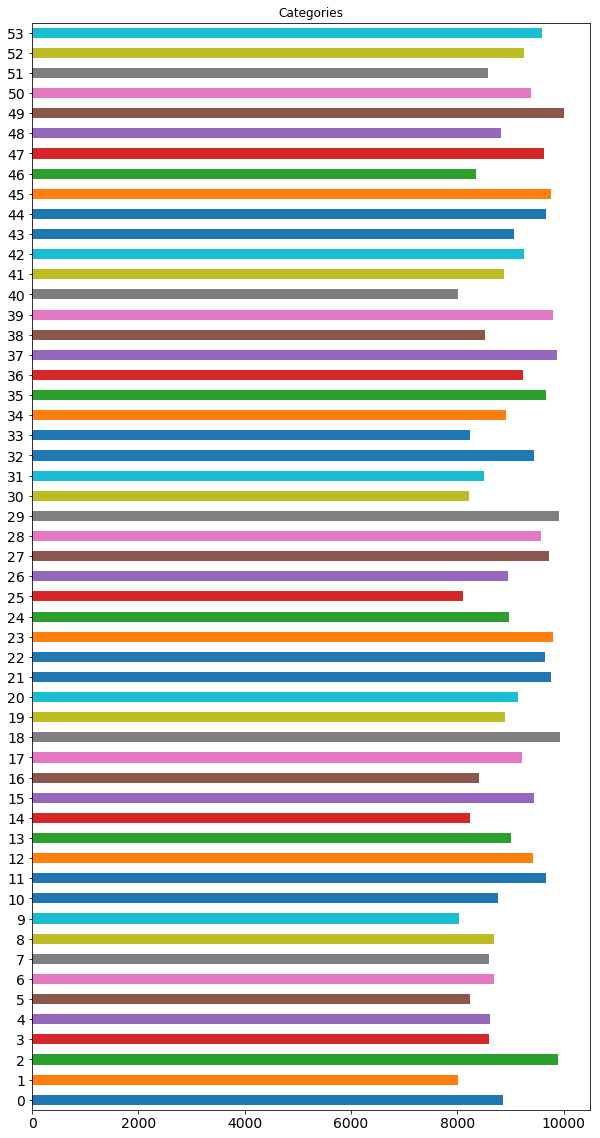

In [17]:
data_train.category_id.value_counts(sort=False).plot(kind="barh", figsize=(10,20), title='Categories', fontsize=14)

Сравнение результата работы обученного классификатора на тренировочных данных (непрозрачные столбцы - истинное распределение, полупрозрачные - результат работы классификатора):

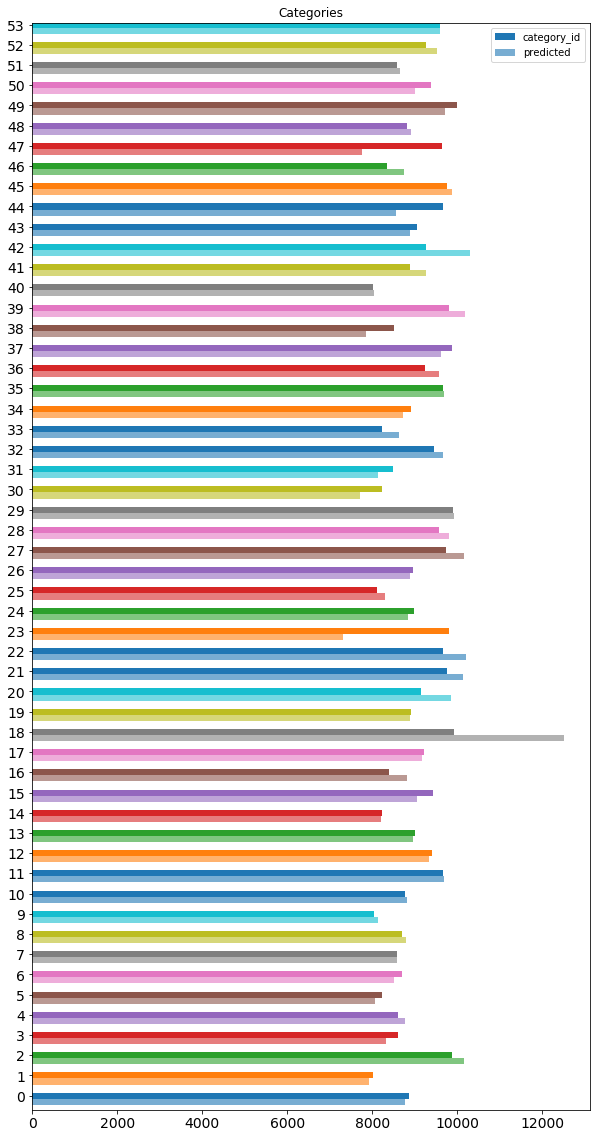

In [18]:
predicted_train = pd.Series(clf.predict(X_train), name='predicted')
data_train.category_id.value_counts(sort=False).plot(kind="barh", figsize=(10,20), width=.3, title='Categories', fontsize=14, legend=True)
predicted_train.value_counts(sort=False).plot(kind="barh", figsize=(10,20), width=.3, title='Categories', fontsize=14, alpha=.6, position=1.5, legend=True)

Обучение классификатора на __3__ уровне иерархии (__'hierarchy_3'__), __accuracy__ и визуализированное представление результата работы алгоритма для данного уровня:

accuracy on train data 0.950046678664888
accuracy with cross validation (K Folds, n=10) 0.9108815624162953


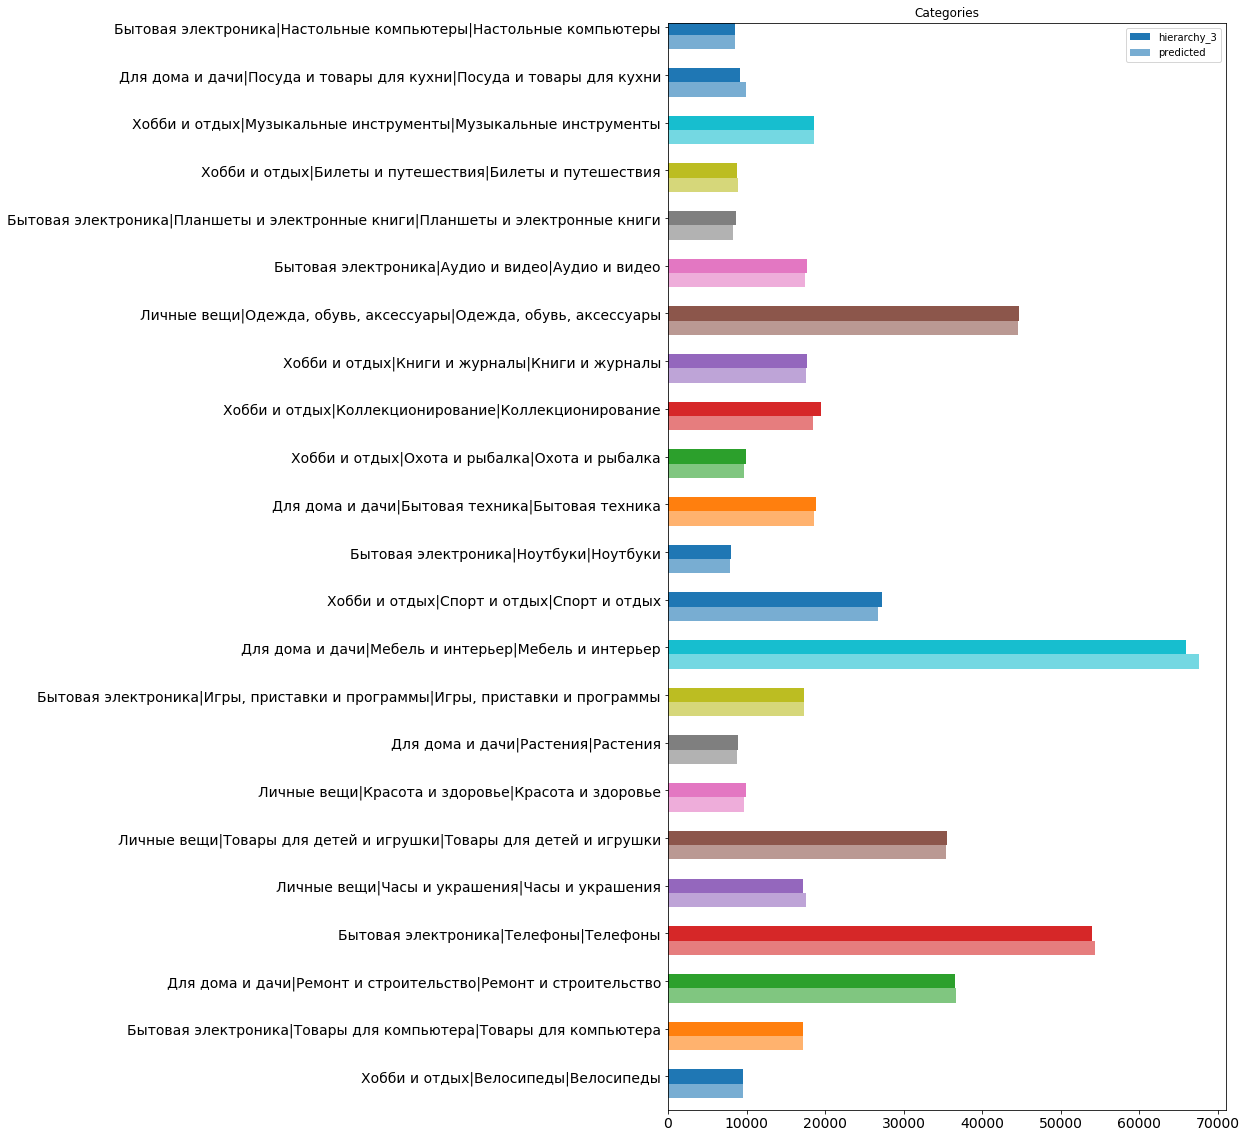

In [19]:
y_reader = data_train['hierarchy_3']
y_train = y_reader

clf = MultinomialNB(alpha=0.1)
clf.fit(X_train, y_train)

print('accuracy on train data', clf.score(X_train, y_train))
print('accuracy with cross validation (K Folds, n=10)', cross_val_score(clf, X_train, y_train, cv=10).mean())

predicted_train = pd.Series(clf.predict(X_train), name='predicted')
data_train.hierarchy_3.value_counts(sort=False).plot(kind="barh", figsize=(10,20), width=.3, title='Categories', fontsize=14, legend=True)
predicted_train.value_counts(sort=False).plot(kind="barh", figsize=(10,20), width=.3, title='Categories', fontsize=14, alpha=.6, position=1.5, legend=True)

Обучение классификатора на __2__ уровне иерархии (__'hierarchy_2'__), __accuracy__ и визуализированное представление результата работы алгоритма для данного уровня:

accuracy on train data 0.950046678664888
accuracy with cross validation (K Folds, n=10) 0.9108815624162953


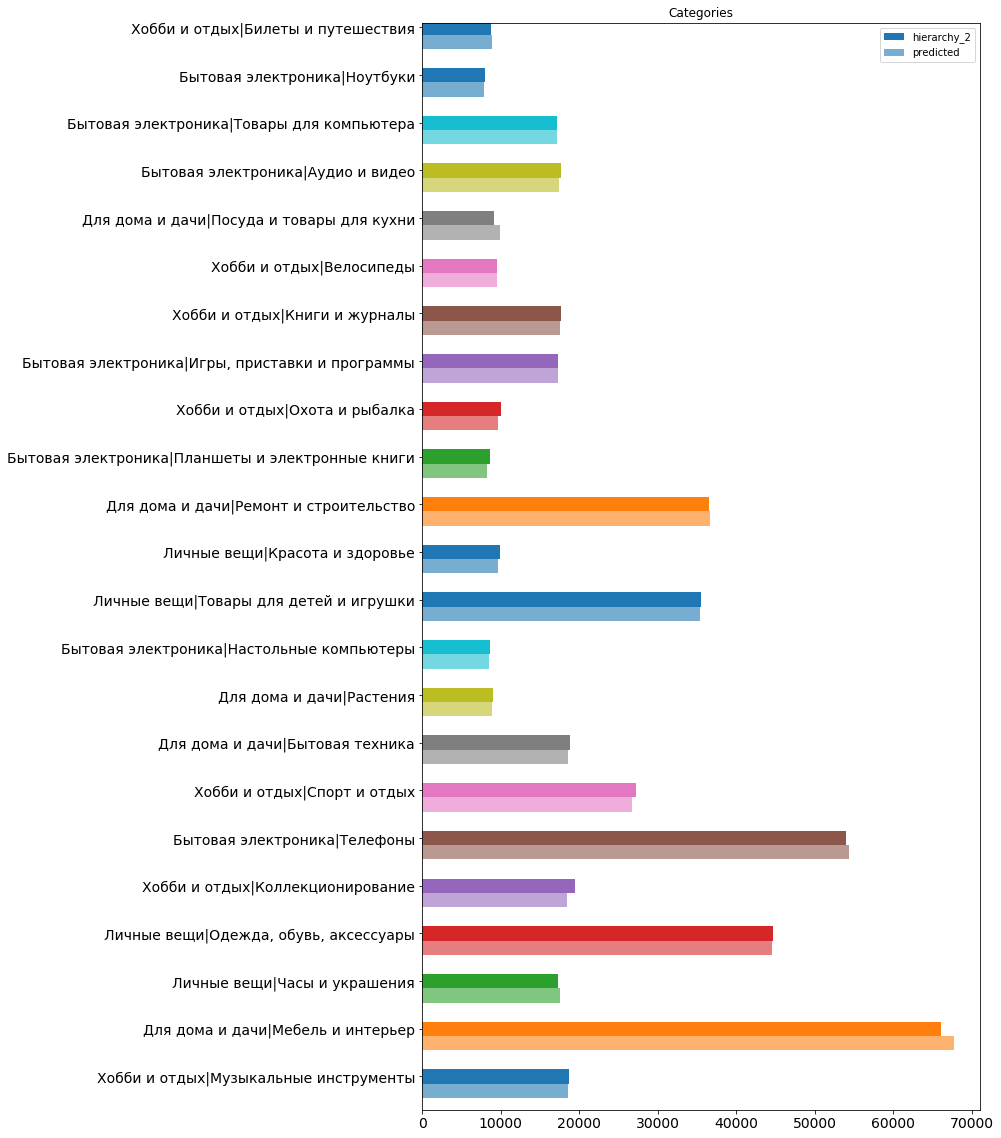

In [20]:
y_reader = data_train['hierarchy_2']
y_train = y_reader

clf = MultinomialNB(alpha=0.1)
clf.fit(X_train, y_train)

print('accuracy on train data', clf.score(X_train, y_train))
print('accuracy with cross validation (K Folds, n=10)', cross_val_score(clf, X_train, y_train, cv=10).mean())

predicted_train = pd.Series(clf.predict(X_train), name='predicted')
data_train.hierarchy_2.value_counts(sort=False).plot(kind="barh", figsize=(10,20), width=.3, title='Categories', fontsize=14, legend=True)
predicted_train.value_counts(sort=False).plot(kind="barh", figsize=(10,20), width=.3, title='Categories', fontsize=14, alpha=.6, position=1.5, legend=True)

Обучение классификатора на __1__ уровне иерархии (__'hierarchy_1'__), __accuracy__ и визуализированное представление результата работы алгоритма для данного уровня:

accuracy on train data 0.962387414533101
accuracy with cross validation (K Folds, n=10) 0.9375772542463465


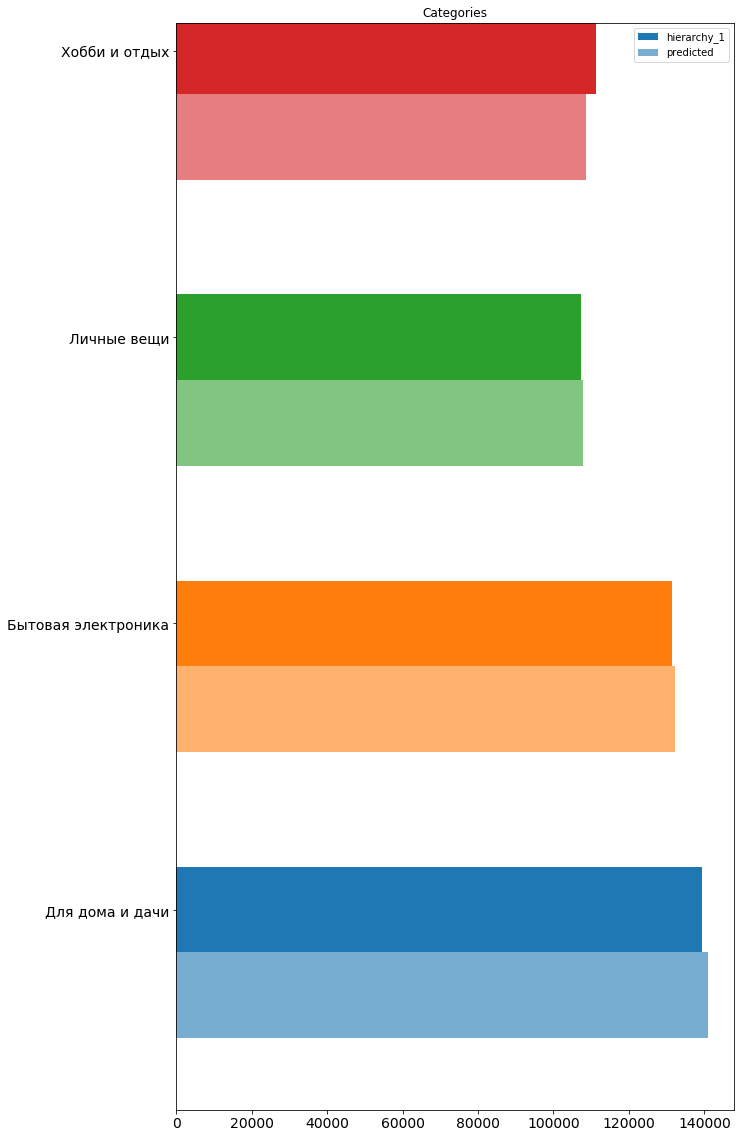

In [21]:
y_reader = data_train['hierarchy_1']
y_train = y_reader

clf = MultinomialNB(alpha=0.1)
clf.fit(X_train, y_train)

print('accuracy on train data', clf.score(X_train, y_train))
print('accuracy with cross validation (K Folds, n=10)', cross_val_score(clf, X_train, y_train, cv=10).mean())

predicted_train = pd.Series(clf.predict(X_train), name='predicted')
data_train.hierarchy_1.value_counts(sort=False).plot(kind="barh", figsize=(10,20), width=.3, title='Categories', fontsize=14, legend=True)
predicted_train.value_counts(sort=False).plot(kind="barh", figsize=(10,20), width=.3, title='Categories', fontsize=14, alpha=.6, position=1.5, legend=True)

Еще одним популярным алгоритмом для обучения при решении задачи классификации текста является _Метод Опорных Векторов_(__Support vector machine, SVM__ https://en.wikipedia.org/wiki/Support_vector_machine), суть которого заключается в построении оптимальной разделяющей гиперплоскости. Ниже данный алгоритм реализован с помощью __sklearn.svm.LinearSVC__. В качестве обучающих данных алгоритм все также принимает названия объявлений __'title'__, а в качестве классов - __'hierarchy_4'__. Дополнительно выводится время, затрачиваемое на обучение классификатора. Можно заметить, что оно значительно превышает аналогичное время для __MultinomialNB__ классификатора:

In [22]:
y_reader = data_train['hierarchy_4']
y_train = y_reader

clf = LinearSVC()
t0 = time()
clf.fit(X_train, y_train);
duration = time() - t0
print('learning duration', duration)

learning duration 182.8787214756012


Вычисление __accuracy__ производится аналогично случаю с __MultinomialNB__. Также дополнительно выводится время, затраченное на кросс-проверку в секундах:

In [27]:
print('accuracy on train data', clf.score(X_train, y_train))
t0 = time()
print('accuracy with cross validation (K Folds, n=10)', cross_val_score(clf, X_train, y_train, cv=10).mean())
duration = time() - t0
print('duration of cross_validation', duration)

accuracy on train data 0.9395261043028128
accuracy with cross validation (K Folds, n=10) 0.8567751360687735
duration of cross_validation 1573.3915627002716


Обучение __LinearSVM__ классификатора на __3__ уровне иерархии (__'hierarchy_3'__), __accuracy__, результат кросс-проверки и время, затраченное на обучение и кросс-проверку в секундах:

In [29]:
y_reader = data_train['hierarchy_3']
y_train = y_reader

clf = LinearSVC()
t0 = time()
clf.fit(X_train, y_train)
duration = time() - t0
print('learning duration', duration)

learning duration 91.13474464416504


In [30]:
print('accuracy on train data', clf.score(X_train, y_train))
t0 = time()
print('accuracy with cross validation (K Folds, n=10)', cross_val_score(clf, X_train, y_train, cv=10).mean())
duration = time() - t0
print('duration of cross_validation', duration)

accuracy on train data 0.971335009815798
accuracy with cross validation (K Folds, n=10) 0.9128651537295683
duration of cross_validation 822.8133811950684


Обучение __LinearSVM__ классификатора на __2__ уровне иерархии (__'hierarchy_2'__), __accuracy__, результат кросс-проверки и время, затраченное на обучение и кросс-проверку в секундах:

In [31]:
y_reader = data_train['hierarchy_2']
y_train = y_reader

clf = LinearSVC()
t0 = time()
clf.fit(X_train, y_train)
duration = time() - t0
print('learning duration', duration)

learning duration 91.27854347229004


In [32]:
print('accuracy on train data', clf.score(X_train, y_train))
t0 = time()
print('accuracy with cross validation (K Folds, n=10)', cross_val_score(clf, X_train, y_train, cv=10).mean())
duration = time() - t0
print('duration of cross_validation', duration)

accuracy on train data 0.971335009815798
accuracy with cross validation (K Folds, n=10) 0.9128651537295683
duration of cross_validation 785.9610834121704


Обучение __LinearSVM__ классификатора на __1__ уровне иерархии (__'hierarchy_1'__), __accuracy__, результат кросс-проверки и время, затраченное на обучение и кросс-проверку в секундах:

In [33]:
y_reader = data_train['hierarchy_1']
y_train = y_reader

clf = LinearSVC()
t0 = time()
clf.fit(X_train, y_train)
duration = time() - t0
print('learning duration', duration)

learning duration 24.375041007995605


In [34]:
print('accuracy on train data', clf.score(X_train, y_train))
t0 = time()
print('accuracy with cross validation (K Folds, n=10)', cross_val_score(clf, X_train, y_train, cv=10).mean())
duration = time() - t0
print('duration of cross_validation', duration)

accuracy on train data 0.9774941421850518
accuracy with cross validation (K Folds, n=10) 0.9395812616749091
duration of cross_validation 239.48013377189636
